In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from sklearn.neighbors import KNeighborsRegressor
from mude_tools import magicplotter
%matplotlib nbagg

## Introduction
In the previous notebook we built a k-nearest neighbors model, and observed the influence of choosing various values for k. We found that choosing k depends, among other things, on the specific dataset used & the noise in this data. By tweaking k we could get a model which __qualitatively__ fit our data well.

In this notebook we will try to __quantify__ how wel a specific model performs for any dataset, this can help us choose the best one. We will start by repeating the code introduced in the previous notebook.

In [2]:
# The true function relating t to x
def f(x, f=1, **kwargs):
    
    # Return a sine with a frequency of f
    return np.sin(x * f)

# The data generation function
def f_data(epsilon=0.7, N=100, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Define a function that makes a KNN prediction at the given locations, based on the given (x,t) data
def KNN(x, t, x_pred, k=1, **kwargs):
    
    # Convert x and x_pred to a column vector in order for KNeighborsRegresser to work
    X = x.reshape(-1,1)
    X_pred = x_pred.reshape(-1,1)
    
    # Train the KNN based on the given (x,t) data
    neigh = KNeighborsRegressor(k)
    neigh.fit(X, t)

    # Make a prediction at the locations given by x_pred
    y = neigh.predict(X_pred)

    # Later we require two predictions from a single KNN predictor.
    # To prevent training it twice, the option to predict for 2 separate sets is created
    if 'extra_predictions' in kwargs:
        x_pred_extra = kwargs.get("extra_predictions").reshape(-1,1)
        return y, neigh.predict(x_pred_extra)

    # Return the predicted values
    return y

## Loss function
To quantify the "closeness" between predictions of some model $y(x)$ and the observed data $t$, we introduce the squared loss function:

$$ L ( t, y(x))= (y(x) - t)^2, $$

where $t$ are the observed values corresponding to $x$. Squaring the difference gives a couple of nice properties:
* The loss is always positive, regardless of whether we underestimate or overestimate a prediction.
* Outliers have a bigger influence on the loss
* It is a convex function
* It is differentiable at $y(x)=t$, which is not true for all loss functions (e.g. the absolute loss)

Below we plot this loss for a number of datapoints. Notice that in this case we are comparing the observations $t$ to the ground truth $f(x)$ (as opposed to some fitted model). The error thus comes solely from the noise in our observations.

<IPython.core.display.Javascript object>


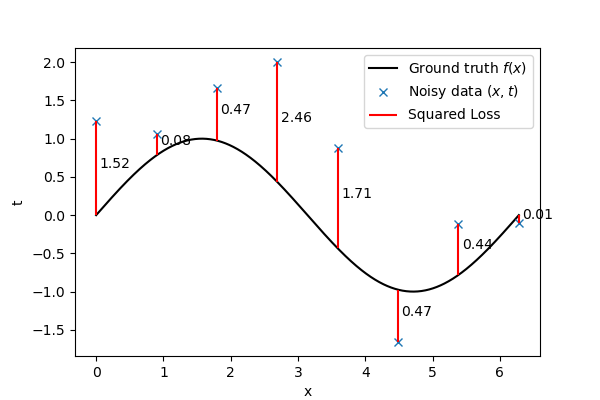

In [3]:
# Get the observed data in 8 locations
x, t = f_data(N=8, seed=0)

# Define the prediction locations
x_pred = np.linspace(0, 2*np.pi, 1000)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))
plt.plot(x_pred, f(x_pred), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')

# Plot the difference and print the squared loss
for i, x_i in enumerate(x):
    ymin = min(t[i], f(x_i))
    ymax = max(t[i], f(x_i))
    if i == 0:    # Only plot the label once
        plt.vlines(x_i, ymin, ymax, 'r', label='Squared Loss')
    else:
        plt.vlines(x_i, ymin, ymax, 'r')
    plt.text(x_i+0.05, (ymin+ymax)/2, f'{(ymax-ymin)**2:.2f}')

plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

* If we create a model that minimizes the loss function for these points, would that model give accurate predictions for unseen data?

## Theory
To quantify our model, we want a single value that tells us how well it explains all the data. Therefore it is natural to compute the expected loss:
$$ \mathbb{E}[L]= \int \int (y(\mathbf{x})-t)^2 p( \mathbf{x},t) d\mathbf{x} dt $$
where $(y(\mathbf{x})-t)^2$ is the error term we have seen before, and we multiply it with $p( \mathbf{x},t)$, the probability of this particular point occuring.

Our goal is to choose a model $y(\mathbf{x})$ so as to minimize $\mathbb{E}[L]$. We can do this using the calculus of variations:

$$ 
\frac{\delta \mathbb{E}[L]}{\delta y(\mathbf{x})}= 2 \int (y(\mathbf{x})-t) p( \mathbf{x},t) dt = 0 
$$

Solving for $y(\mathbf{x})$:

$$
\int y(\mathbf{x}) p( \mathbf{x},t) dt = \int t p( \mathbf{x},t) dt \\
y(\mathbf{x}) p( \mathbf{x}) = \int t p( \mathbf{x},t) dt \\
y(\mathbf{x}) = \frac{\int t p( \mathbf{x},t) dt}{p(\mathbf{x})} = \int t p(t|\mathbf{x})dt = \mathbb{E}_t[t|\mathbf{x}]
$$

In other words, the model that minimizes the squared loss is given by the mean of the conditional distribution $p(t|\mathbf{x})$.

In practice we generally don't know $p( \mathbf{x},t)$ or $p(t|\mathbf{x})$ exactly. Instead for any model we can estimate the loss by taking the average of the squared losses for each point in our limited dataset. We can then tweak $y(\mathbf{x})$ to minimize this loss.

$$ \int \int (y(\mathbf{x})-t)^2 p( \mathbf{x},t) d\mathbf{x} dt \approx \dfrac{1}{N} \sum_i^N (y(\mathbf{x}_i)-t_i)^2 $$

This is known as the Mean Squared Error (MSE) function.

We revisit our k-nearest neighbors model, now with the loss function included.



<IPython.core.display.Javascript object>


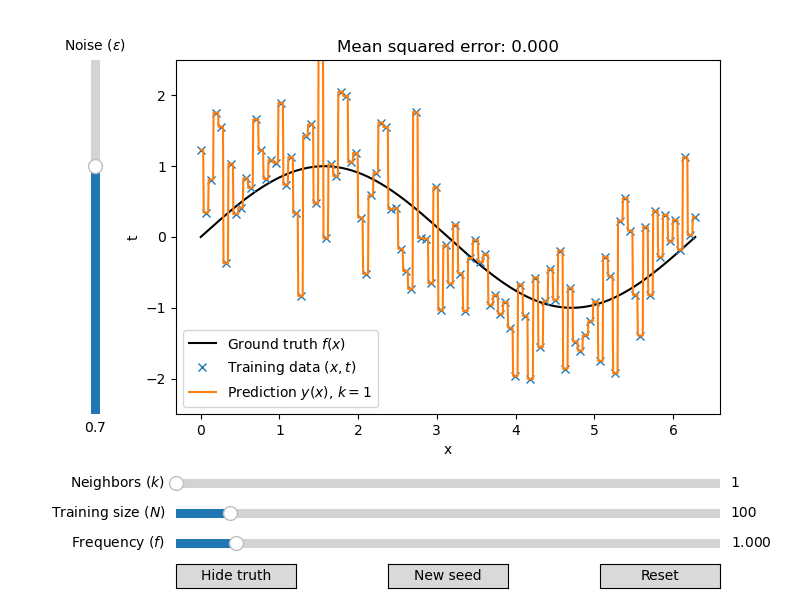

In [4]:
# Get the observed data
x, t = f_data(N=100)

# Define the prediction locations
x_pred = np.linspace(0, 2*np.pi, 1000)

# Create the interactive plot including training error
plot1 = magicplotter(f_data, f, KNN, x_pred)
plot1.add_sliders('epsilon', 'k', 'N', 'f')
plot1.add_buttons('truth', 'seed', 'reset')
plot1.title = 'Mean squared error: {mse_train:.3f}'
plot1.show()

## Model selection
For k = 1 our error term is 0, yet the resulting model will not yield good predictions for unseen data. Our model has fitted the noise in the dataset, and therefore does not generalize well. We say that we have __overfitted__ our model to the training data. Clearly, evaluating the squared loss solely on our training points does not suffice.

To solve this problem a validation set is introduced. This set consists of different observations from the same ground truth which are not included during training.

|   |   |
| :--- | :--- |
| **Training Loss:** | The value of the loss function based on all observations used to train a model |
| **Validation Loss:** | The value of the loss function based on observations not used during training, used for finding hyperparameters such as $k$ |
| **Test Loss:** | The value of the loss function based on observations not used during either training or validation, used for evaluating the fit of the final model (for example to compare to alternative models) |

We repeat the experiment above with an additional validation set for which we compute the validation loss. This validation error represents the error we obtain when making new predictions and is therefore a much better indication for assessing our model compared to the training error. Minimizing the error on this validation set allows us to find a good value for k.
<!-- Depending on the problem, it might not always be possible to simply create more data. Therefore we split the data we have into 2 seperate sets; one for training and one for validation. (Making sure to randomly shuffle the data before splitting) -->

<IPython.core.display.Javascript object>


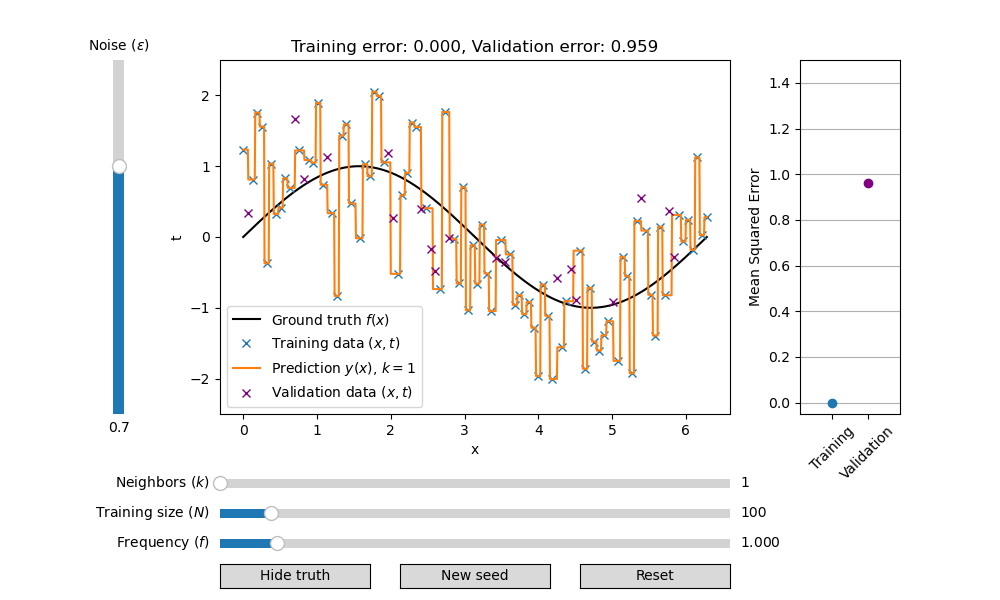

In [5]:
# Get the observed data
x, t = f_data(N=100)

# Define the prediction locations
x_pred = np.linspace(0, 2*np.pi, 1000)

# Create the interactive plot including training error
plot2 = magicplotter(f_data, f, KNN, x_pred)
plot2.add_sliders('epsilon', 'k', 'N', 'f')
plot2.add_buttons('truth', 'seed', 'reset')
plot2.add_sidebar()
plot2.title = 'Training error: {mse_train:.3f}, Validation error: {mse_validation:.3f}'
plot2.show()

* For a training size $(N)$ of 100 and a frequency $(f)$ of 1, what is the value of $k$ for which the validation error is minimized?

## Bias-variance tradeoff

As we determined earlier, the optimal prediction (in the sense that it minimizes the squared loss function), which we will denote as $h(\mathbf{x})$, is given by:

$$ 
    h(\mathbf{x})= \mathbb{E}[t|\mathbf{x}] = \int t p(t|\mathbf{x})dt 
$$

The expected loss can be written as:

$$
    \begin{aligned}
        \mathbb{E}[L] &= \int \left(y(\mathbf{x}) - t\right)^2 d\mathbf{x} \\
        &= \int \left(y(\mathbf{x}) - h(\mathbf{x}) + h(\mathbf{x}) - t \right)^2 p(\mathbf{x}) d\mathbf{x} \\
        &= \int \left(y(\mathbf{x}) - h(\mathbf{x})\right)^2 p(\mathbf{x}) d\mathbf{x} + \int \left(h(\mathbf{x}) - t \right)^2 p(\mathbf{x}) d\mathbf{x} + 2 \int \left(y(\mathbf{x}) - h(\mathbf{x})\right)\left(h(\mathbf{x}) - t\right) p(\mathbf{x}) d\mathbf{x} \\
        &= \underbrace{\int \left(y(\mathbf{x}) - h(\mathbf{x})\right)^2 p(\mathbf{x}) d\mathbf{x}}_{\text{reducible loss}} + \underbrace{\int \left(h(\mathbf{x}) - t \right)^2 p(\mathbf{x}) d\mathbf{x}}_{\text{irreducible noise}} \\
    \end{aligned}
$$

where in the last step, it can be shown that the last integral evaluates to $0$. The irreducible noise term represents the variance that will always be present in our model, because we make noisy observations. Even if we had the perfect model, we would still have an expected loss that is greater than $0$, due to the noise inherent in our data. __should we do a callback here to the previous plots with $k=0$?__

Now, focusing on the first term, we might note that actually our model $y(\mathbf{x})$ not only depends on $\mathbf{x}$, but also on which dataset $\mathcal{D}$ we used. So, the first integral should be replaced as follows:

$$
    \int \left(y(\mathbf{x}) - h(\mathbf{x})\right)^2 p(\mathbf{x}) d\mathbf{x} \rightarrow \int \mathbb{E}_\mathcal{D}\left[\left(y(\mathbf{x},\mathcal{D}) - h(\mathbf{x})\right)^2\right] p(\mathbf{x}) d\mathbf{x} 
$$

Now, we do some rearrangement in the inner part of this expression:

$$
    \begin{aligned}
        \left(y(\mathbf{x},\mathcal{D}) - h(\mathbf{x})\right)^2 &= \left(y(\mathbf{x},\mathcal{D}) - \mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right] + \mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right] - h(\mathbf{x})\right)^2 \\
        &= \left(y(\mathbf{x},\mathcal{D}) - \mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right]\right)^2 + \left(\mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right] - h(\mathbf{x})\right)^2 + 2 \left(y(\mathbf{x},\mathcal{D}) - \mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right]\right)\left(\mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right] - h(\mathbf{x})\right) \\
    \end{aligned}
$$

and then taking the expectation over all datasets:

$$
    \begin{aligned}
\mathbb{E}_\mathcal{D}\left[\left(y(\mathbf{x},\mathcal{D}) - h(\mathbf{x})\right)^2\right] &= \mathbb{E}_\mathcal{D}\left[\left(y(\mathbf{x},\mathcal{D}) - \mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right]\right)^2\right] + \mathbb{E}_\mathcal{D}\left[\left(\mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right] - h(\mathbf{x})\right)\right]^2 + 0 \\
        &= \underbrace{\mathbb{E}_\mathcal{D}\left[\left(y(\mathbf{x},\mathcal{D}) - \mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right]\right)^2\right]}_{\text{variance}} + \underbrace{\left\{\mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right] - h(\mathbf{x})\right\}^2}_{\text{bias}}
    \end{aligned}
$$

Overall, the expected loss can be decomposed as follows:

$$
    \text{expected loss} = \text{bias}^2 + \text{variance} + \text{noise}
$$

These three terms can be understood as follows:

- __Bias__: the bias represents the mismatch between the expectaction of our model $\mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right]$ and the optimal model $h(\mathbf{x})$. An __unbiased__ model will on average give us the optimal prediction, whereas a __biased__ model will on average deviate from the optimal prediction.
- __Variance__: the variance represents the degree to which our model $y(\mathbf{x},\mathcal{D})$ deviates from the average model $\mathbb{E}_\mathcal{D}\left[y(\mathbf{x},\mathcal{D})\right]$. If the variance is large, it means that a new dataset would produce a very different model.
- __Noise__: the noise represents the variation that is inherent to our dataset. This term cannot be reduced, because it stems from our data, and not from our choice of model.

Generally speaking, there is a certain balance to strike between the bias and the variance. Models that are more flexible tend to target, on average, the optimal prediction, but can be greatly influenced by the dataset to which they are fitted. In other words, they have a lower bias, but a larger variance. On the other hand, models that are more inflexible tend to be less affected by the dataset to which they are fitted, but this causes them to deviate from the optimal prediction. In other words, they have a lower variance, but a larger bias. This dilemma is referred to as the __bias-variance tradeoff__.

For a more complete discussion we refer to Chapter 3.2 of "Bishop - Pattern Recognition And Machine Learning"

Looking back at the plot above try to answer the following questions:
* When k is low, do we have a high or low bias? And what about the variance?
* When k is high, do we have a high or low bias? And what about the variance?

We will now quantify the bias and variance by creating a large number of datasets and averaging over them, following the equation above. Notice that this is only possible because we know the true model in this example.
The code in the cell below is all we need to compute to average over all the models

In [6]:
def make_preds(x, x_pred, num_models, N, k, l, noise):

    # reset seed to get the same results
    seed = 0

    # Array to store mean prediction in; required for computing the bias
    y_plot_mean_pred = np.zeros(len(x_pred))
    y_eval_mean_pred = np.zeros(len(x))
    # Store each model output; required for computing the variance
    model_ys = []

    # We average over many models with independent datasets
    for i in range(num_models):
        # Create a new random dataset
        seed += 1
        t = f(x, l) + np.random.normal(0, noise, N)

        # Run our k-nearest neighbor model
        y_plot, y_eval = KNN(x, t, x_pred, k, extra_predictions=x)

        # Store predictions
        y_plot_mean_pred += y_plot / num_models
        y_eval_mean_pred += y_eval / num_models
        model_ys.append(y_eval)
    # Compute the average bias
    # Note: if the noise was dependent on the value of x, this single average would give a distorted view
    bias = np.sqrt(sum((y_eval_mean_pred - f(x, l))**2)/N)

    # Compute the variance
    # variances = np.zeros(len(x_pred))
    variance = np.zeros(N)
    for y in model_ys:
        variance += ((y-y_eval_mean_pred)**2)
    variance /= num_models

    return y_plot_mean_pred, bias, variance

### The plot we create next is only used once, and therefore not implemented in the 'magicplotter'. You can skip reading the next cell (but still run it to see the plot!)

<IPython.core.display.Javascript object>


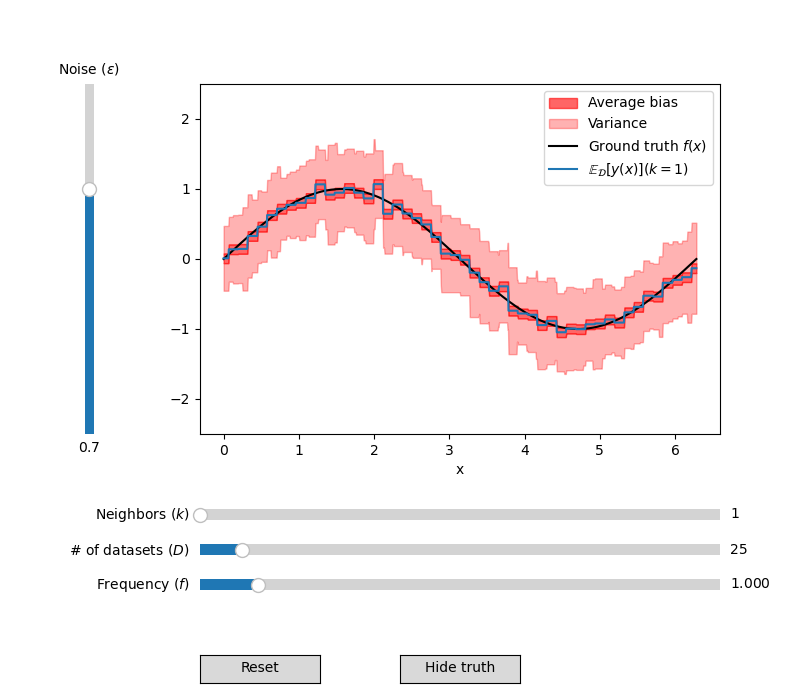

In [7]:
# Set default values
N = 50
num_models = 100
plot_length = 1000
k = 1
l = 1
noise = 0.7
x = np.linspace(0, 2*np.pi, N)

# Run initial simulation:
y_plot_mean_pred, bias_val, variance_vals = make_preds(x, x_pred, num_models, N, k, l, noise)

# Computing intervals for plotting bias & variance
bias_bottom = y_plot_mean_pred-[bias_val]
bias_top = y_plot_mean_pred+[bias_val]
variance_plot_vals = np.repeat(variance_vals, int(plot_length/N))
variance_lower1 = y_plot_mean_pred-[bias_val]-variance_plot_vals
variance_lower2 = y_plot_mean_pred-[bias_val]
variance_upper1 = y_plot_mean_pred+[bias_val]
variance_upper2 = y_plot_mean_pred+[bias_val]+variance_plot_vals

fig, ax = plt.subplots(figsize=(8,7))

bias = ax.fill_between(x_pred, bias_bottom, bias_top, alpha=0.6, color='red', label='Average bias')
variance_1 = ax.fill_between(x_pred, variance_lower1, variance_lower2, color='red', alpha=0.3, label='Variance')
variance_2 = ax.fill_between(x_pred, variance_upper1, variance_upper2, color='red', alpha=0.3)
truth, = ax.plot(x_pred, f(x_pred, l), 'k-', label=r'Ground truth $f(x)$')
pred, = ax.plot(x_pred, y_plot_mean_pred, '-', label=r'$\mathbb{E}_{\mathcal{D}}[y(x)](k=$' + f'{k}$)$' )
ax.set_xlabel('x')
ax.set_ylim((-2.5, 2.5))
ax.legend()

# Adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.38)

###########
# Sliders #
###########

# Make a horizontal slider to control the number of neighbors
ax_k = plt.axes([0.25, 0.25, 0.65, 0.03])
k_slider = Slider(
    ax=ax_k,
    label=r'Neighbors ($k$)',
    valmin=1,
    valmax=50,
    valinit=1,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the number of datasets
ax_D = plt.axes([0.25, 0.20, 0.65, 0.03])
D_slider = Slider(
    ax=ax_D,
    label=r'# of datasets ($D$)',
    valmin=1,
    valmax=300,
    valinit=25,
    valfmt='%0.0f'
)

# Make a horizontal slider to control the number of measurements
# ax_N = plt.axes([0.25, 0.15, 0.65, 0.03])
# N_slider = Slider(
#     ax=ax_N,
#     label=r'Training size ($N$)',
#     valmin=2,
#     valmax=200,
#     valinit=N,
#     valfmt='%0.0f'
# )

# Make a horizontal slider to control the frequency
ax_l = plt.axes([0.25, 0.15, 0.65, 0.03])  #plt.axes([0.25, 0.1, 0.65, 0.03])
l_slider = Slider(
    ax=ax_l,
    label=r'Frequency ($f$)',
    valmin=1/8,
    valmax=8,
    valinit=1,
)

# Make a vertical slider to control the noise level
ax_eps = plt.axes([0.10, 0.38, 0.0225, 0.50])
eps_slider = Slider(
    ax=ax_eps,
    label=r'Noise ($\varepsilon$)',
    valmin=0,
    valmax=1,
    valinit=noise,
    orientation="vertical"
)

# Define an update function when a slider value changes
def update(event):

    # Get the slider values
    k = int(k_slider.val)  #min(k_slider.val, N_slider.val))
    D = int(D_slider.val)
    N = 50  #int(N_slider.val)
    l = l_slider.val
    noise = eps_slider.val

    # Run the models
    y_plot_mean_pred, bias_val, variance_vals = make_preds(x, x_pred, D, N, k, l, noise)

    # Update plots
    # Computing intervals for plotting bias & variance
    bias_bottom = y_plot_mean_pred-[bias_val]
    bias_top = y_plot_mean_pred+[bias_val]
    variance_plot_vals = np.repeat(variance_vals, int(plot_length/N))
    variance_lower1 = y_plot_mean_pred-[bias_val]-variance_plot_vals
    variance_lower2 = y_plot_mean_pred-[bias_val]
    variance_upper1 = y_plot_mean_pred+[bias_val]
    variance_upper2 = y_plot_mean_pred+[bias_val]+variance_plot_vals

    # Fills cannot be updated but are re-plotted
    global bias
    global variance_1
    global variance_2
    bias.remove()
    variance_1.remove()
    variance_2.remove()
    bias = ax.fill_between(x_pred, bias_bottom, bias_top, color='red', alpha=0.6, label='Average bias')
    variance_1 = ax.fill_between(x_pred, variance_lower1, variance_lower2, color='red', alpha=0.3, label='variance')
    variance_2 = ax.fill_between(x_pred, variance_upper1, variance_upper2, color='red', alpha=0.3)

    truth.set_data(x_pred, f(x_pred,l))
    pred.set_ydata(y_plot_mean_pred)

    # Update the legend
    pred.set_label(r'$\mathbb{E}_{\mathcal{D}}[y(x)](k=$' + f'{k}$)$')
    ax.legend()

    fig.canvas.draw_idle()

# Define a function that hides the ground truth
def toggle_truth(event):

    if truth.get_alpha() is None:
        truth.set_alpha(0)
        truth_button.label.set_text('Show truth')
    else:
        truth.set_alpha(None)
        truth_button.label.set_text('Hide truth')

    # update(event)

# Define a function that performs a reset
def reset_all(event):

    k_slider.reset()
    D_slider.reset()
    # N_slider.reset()
    l_slider.reset()
    eps_slider.reset()

    if not truth.get_alpha() is None:
        toggle_truth(event)

    update(event)

# Connect the update function to each slider
k_slider.on_changed(update)
D_slider.on_changed(update)
# N_slider.on_changed(update)
l_slider.on_changed(update)
eps_slider.on_changed(update)

###########
# Buttons #
###########

# Make a button to hide/show the truth
ax_truth = plt.axes([0.50, 0.025, 0.15, 0.04])
truth_button = Button(ax_truth, 'Hide truth', hovercolor='0.975')

# Make a button to go back to the initial settings
ax_reset = plt.axes([0.25, 0.025, 0.15, 0.04])
reset_button = Button(ax_reset, 'Reset', hovercolor='0.975')

truth_button.on_clicked(toggle_truth)
reset_button.on_clicked(reset_all)
plt.show()

## Playing around with the plot
Understanding bias and variance is key for any method you use, and this will come back in many of the following lectures. Being able to answer some of the following questions can help you understand what is going on:
* Why is the variance small for a large $k$?
* Why is the bias not zero for $k=1$?
* Why does the bias increase when choosing a high frequency $f$?
* Why is the variance 0 when using a single dataset $D$?
* What would change if the noise $\varepsilon$ was dependent on x? (e.g. $\varepsilon$ increases for increasing $x$)



## Final remarks

So far we have looked at our k-nearest neighbors regressor, which is relatively easy to understand and play around with. However in practice this method is not often used, as it scales poorly for large datasets. Furthermore, when considering multiple inputs (high-dimensions) computing the closest points becomes computationally expensive. In a limited data setting, taking the average of the closest neighbors will often lead to poor performance. k-nearest neighbors is also sensitive to outliers. In the next lecture, we will apply what we have learned to a different model, namely linear regression.

## Note for reviewer: in the final code I disabled the part for the N slider, as updating it would crash the plot for me. I also don't think it adds that much insight. If you agree I can remove the remnants in the code